# How to Train YOLO11 Object Detection on a Custom Dataset

## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Aug  7 06:05:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 60%   51C    P2             95W /  200W |    3615MiB /  12282MiB |     55%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = 'd:/Code/yolo_tutorial'
print(HOME)

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

d:/Code/yolo_tutorial


## Install YOLO11 via Ultralytics

In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40  Python-3.12.4 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
Setup complete  (20 CPUs, 31.8 GB RAM, 286.8/346.9 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [4]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

Ultralytics 8.3.40 🚀 Python-3.12.4 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 d:\Code\yolo_tutorial\dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 51.0ms
Speed: 1.5ms preprocess, 51.0ms inference, 53.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\detect\predict
💡 Learn more at https://docs.ultralytics.com/modes/predict



  0%|          | 0.00/5.35M [00:00<?, ?B/s]
  2%|▏         | 128k/5.35M [00:00<00:05, 1.09MB/s]
  9%|▉         | 512k/5.35M [00:00<00:02, 2.46MB/s]
 30%|███       | 1.62M/5.35M [00:00<00:00, 4.14MB/s]
 49%|████▉     | 2.62M/5.35M [00:00<00:00, 5.74MB/s]
 65%|██████▌   | 3.50M/5.35M [00:00<00:00, 5.42MB/s]
 86%|████████▋ | 4.62M/5.35M [00:00<00:00, 5.99MB/s]
100%|██████████| 5.35M/5.35M [00:00<00:00, 5.73MB/s]

  0%|          | 0.00/104k [00:00<?, ?B/s]
100%|██████████| 104k/104k [00:00<00:00, 976kB/s]
100%|██████████| 104k/104k [00:00<00:00, 976kB/s]


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

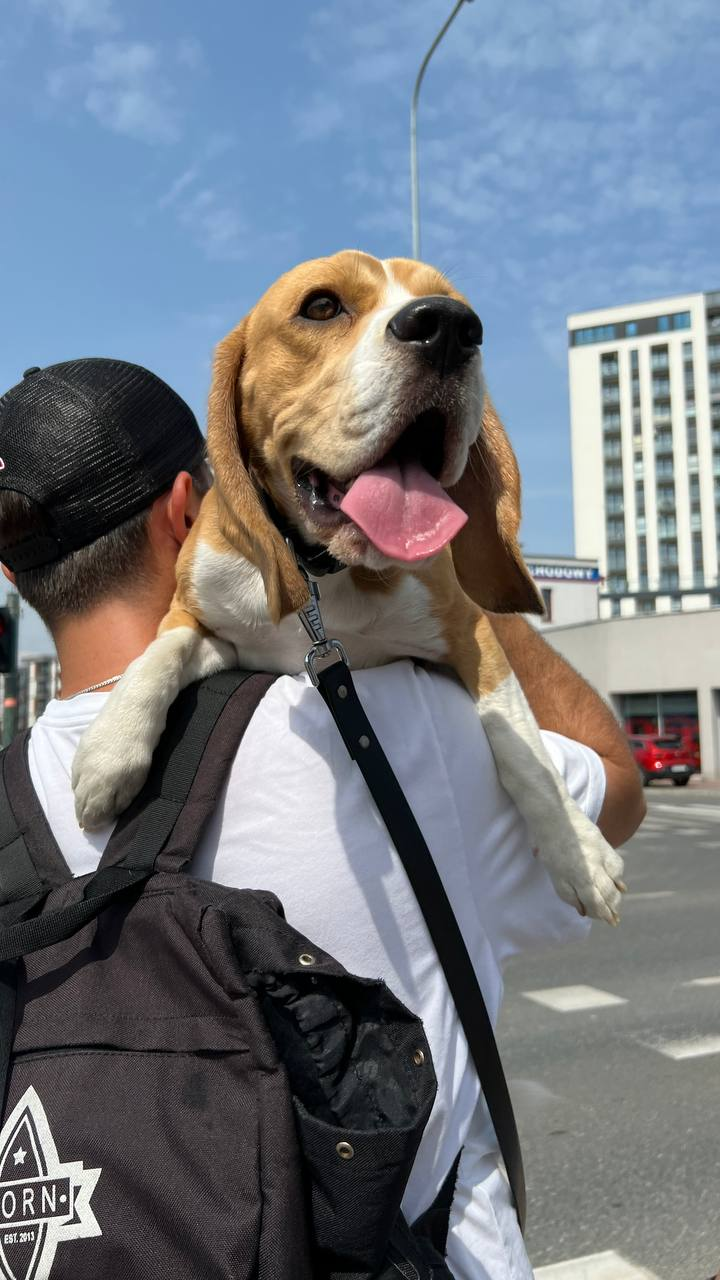

In [5]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'dog.jpeg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [6]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 55.8ms
Speed: 2.6ms preprocess, 55.8ms inference, 53.8ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [7]:
result.boxes.xyxy
print(f"Detected {len(result.boxes)} objects")

print("The bounding boxes are in the format [x1, y1, x2, y2] where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner.")
print(result.boxes.xyxy)
print("The confidence scores for each detected object:")
print(result.boxes.conf)
print("The class IDs for each detected object:")
print(result.boxes.cls)

Detected 5 objects
The bounding boxes are in the format [x1, y1, x2, y2] where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner.
tensor([[3.0704e+02, 6.4348e+02, 5.2916e+02, 1.2544e+03],
        [5.9770e+01, 2.4956e+02, 6.5153e+02, 9.8324e+02],
        [1.7676e+00, 3.5559e+02, 6.3395e+02, 1.2788e+03],
        [1.1573e+00, 3.5702e+02, 4.4425e+02, 1.2761e+03],
        [6.2583e+02, 7.1805e+02, 6.9974e+02, 7.8754e+02]], device='cuda:0')
The confidence scores for each detected object:
tensor([0.6866, 0.6338, 0.5930, 0.4699, 0.3913], device='cuda:0')
The class IDs for each detected object:
tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')


**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [8]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

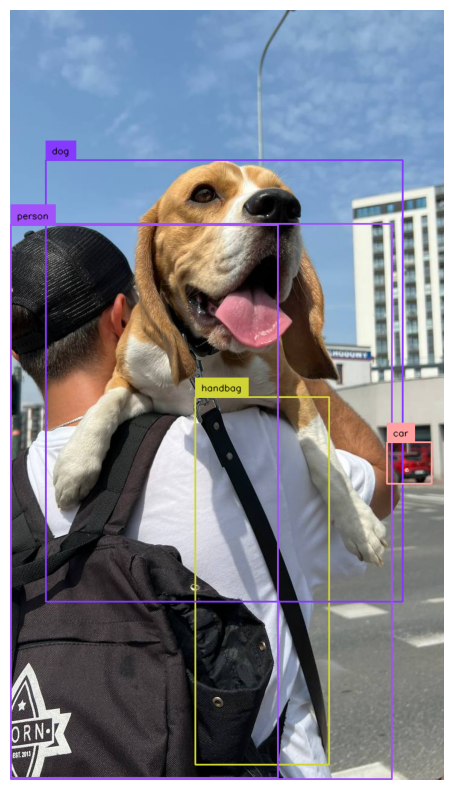

In [9]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [10]:
!mkdir datasets

In [11]:
%cd {HOME}/datasets


from roboflow import Roboflow
rf = Roboflow(api_key="NPrs7hcoYiv4EiGwJImh")
project = rf.workspace("cortex").project("forklift-dsitv-ogqpy")
version = project.version(1)
dataset = version.download("yolov11")

d:\Code\yolo_tutorial\datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Forklift-1 in yolov11:: 100%|██████████| 2034/2034 [00:00<00:00, 3233.82it/s]


## Custom Training

In [12]:
print(dataset.location)

d:\Code\yolo_tutorial\datasets\Forklift-1


In [13]:
%cd {HOME}

model = YOLO('yolo11s.pt')
model.train(data=f'{HOME}/datasets/Forklift-1/data.yaml', epochs=15, imgsz=640, device='cuda')

d:\Code\yolo_tutorial


100%|██████████| 18.4M/18.4M [00:03<00:00, 5.52MB/s]


New https://pypi.org/project/ultralytics/8.3.175 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.40  Python-3.12.4 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=d:/Code/yolo_tutorial/datasets/Forklift-1/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

train: Scanning D:\Code\yolo_tutorial\datasets\Forklift-1\train\labels... 885 images, 0 backgrounds, 0 corrupt: 100%|██████████| 885/885 [00:00<00:00, 969.74it/s]

train: New cache created: D:\Code\yolo_tutorial\datasets\Forklift-1\train\labels.cache



val: Scanning D:\Code\yolo_tutorial\datasets\Forklift-1\valid\labels... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 632.88it/s]

val: New cache created: D:\Code\yolo_tutorial\datasets\Forklift-1\valid\labels.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      4.42G      1.252      2.247      1.524         18        640: 100%|██████████| 56/56 [00:22<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         84        171      0.453      0.426      0.317      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      4.37G      1.355      1.488      1.642         18        640: 100%|██████████| 56/56 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

                   all         84        171      0.165      0.184     0.0932     0.0311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      4.43G      1.427       1.48      1.697         27        640: 100%|██████████| 56/56 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         84        171      0.348      0.348      0.249     0.0758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      4.41G      1.372      1.373      1.671         25        640: 100%|██████████| 56/56 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         84        171      0.649       0.39      0.416      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15       4.4G      1.317      1.296       1.63         22        640: 100%|██████████| 56/56 [00:16<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         84        171      0.446      0.421       0.38      0.176


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15       4.4G      1.369      1.386      1.775         10        640: 100%|██████████| 56/56 [00:16<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         84        171      0.673      0.502      0.541      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      4.37G       1.32      1.279      1.728          8        640: 100%|██████████| 56/56 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         84        171      0.604      0.619      0.581      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      4.38G      1.248      1.123      1.636         13        640: 100%|██████████| 56/56 [00:16<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

                   all         84        171      0.714      0.583      0.621      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      4.37G      1.154      1.028      1.579          9        640: 100%|██████████| 56/56 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         84        171      0.704      0.604      0.644      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      4.37G      1.063     0.9393      1.483          9        640: 100%|██████████| 56/56 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all         84        171      0.753      0.612      0.677        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      4.41G     0.9827     0.8403      1.418          8        640: 100%|██████████| 56/56 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         84        171      0.816      0.671      0.727      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      4.38G     0.9291     0.7569      1.375          8        640: 100%|██████████| 56/56 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

                   all         84        171      0.731      0.707      0.718      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      4.39G     0.8731     0.6811      1.346         11        640: 100%|██████████| 56/56 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         84        171      0.769      0.685      0.707      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      4.37G     0.8449     0.6456       1.28         12        640: 100%|██████████| 56/56 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         84        171       0.78      0.691      0.733      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      4.37G     0.7633     0.5749      1.223         10        640: 100%|██████████| 56/56 [00:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

                   all         84        171      0.833        0.7      0.743      0.498



15 epochs completed in 0.084 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 19.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 19.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.40  Python-3.12.4 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


                   all         84        171      0.832        0.7      0.741      0.498
              forklift         83         96      0.957      0.854      0.917      0.677
                person         40         75      0.707      0.547      0.565      0.319
Speed: 0.5ms preprocess, 3.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000026096ECC140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

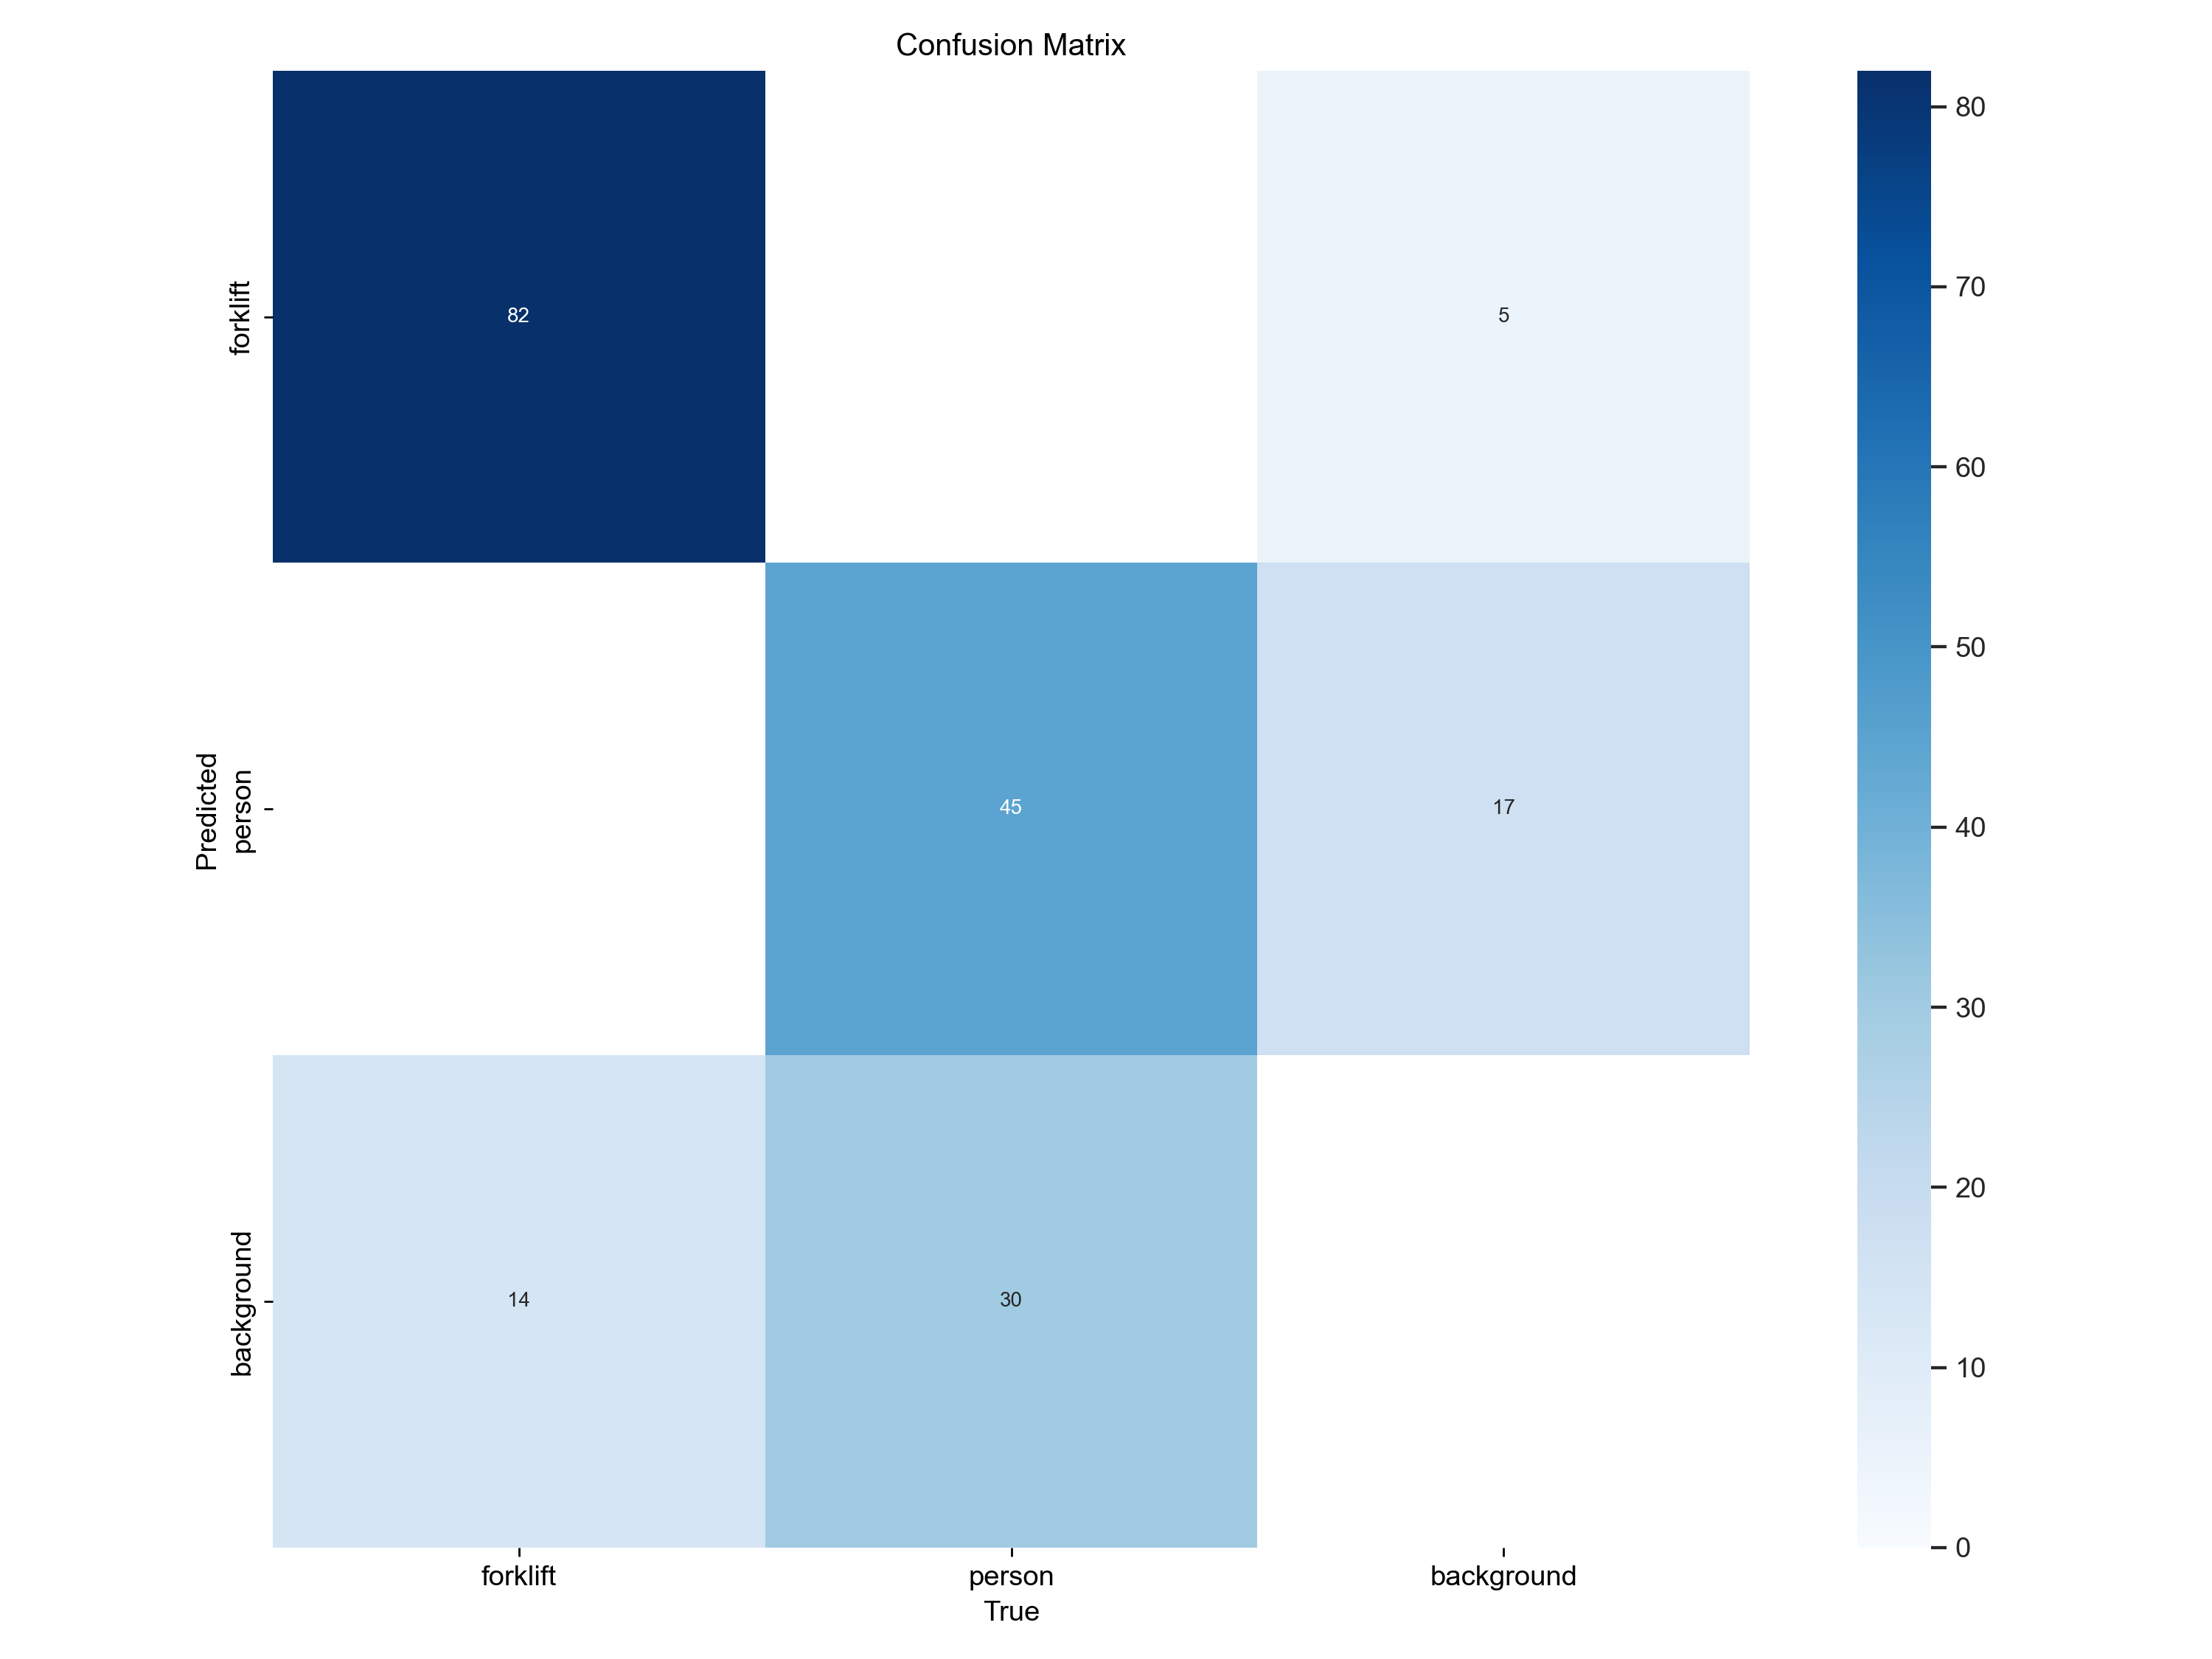

In [14]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

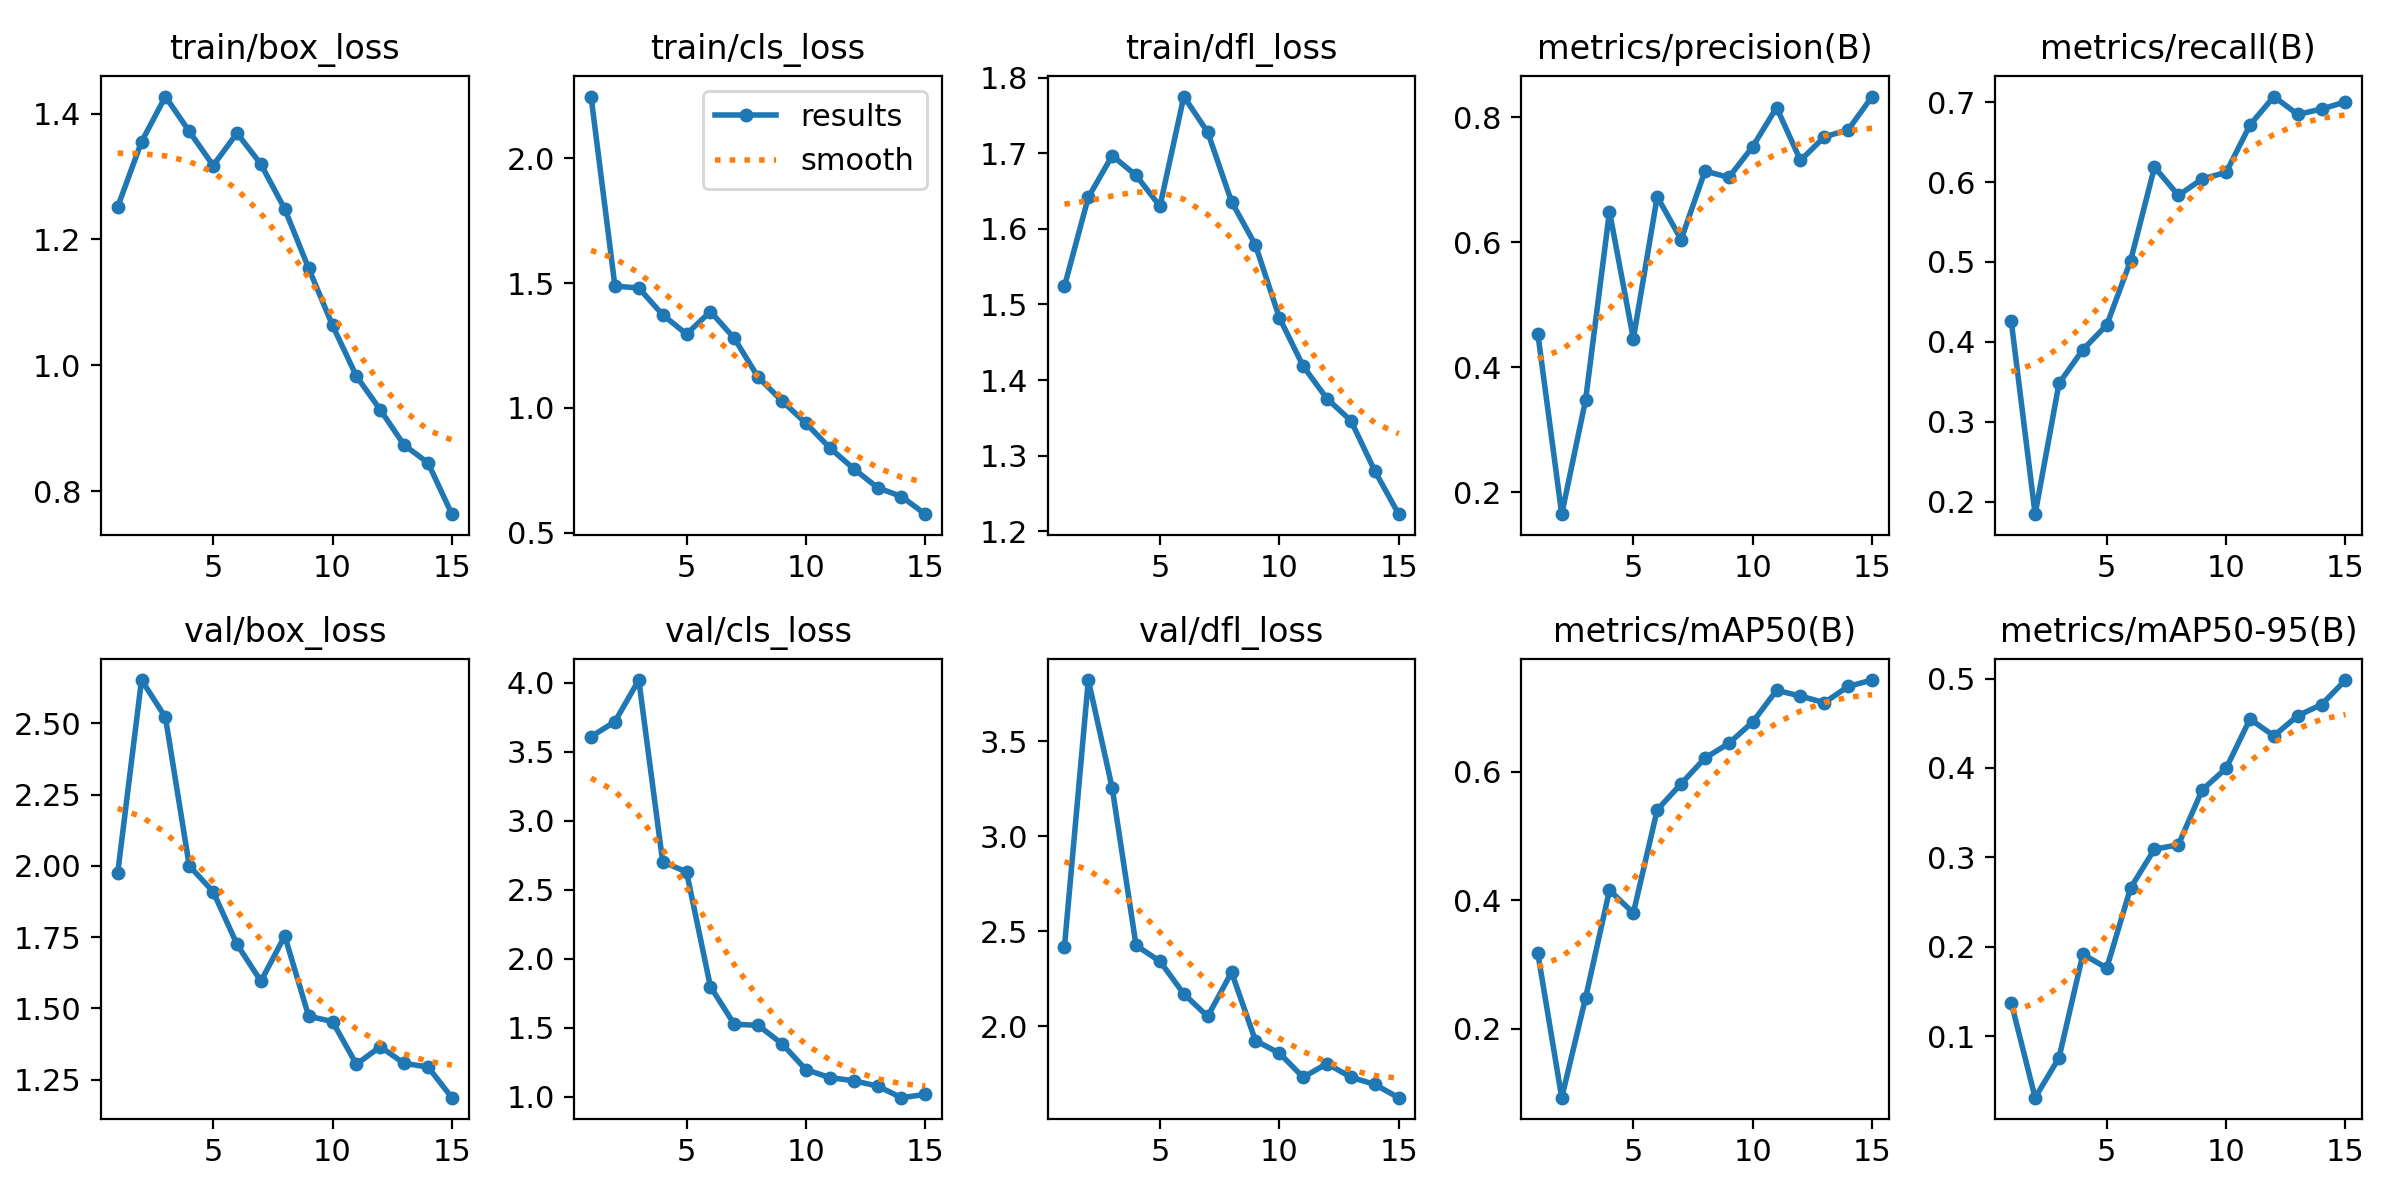

In [15]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

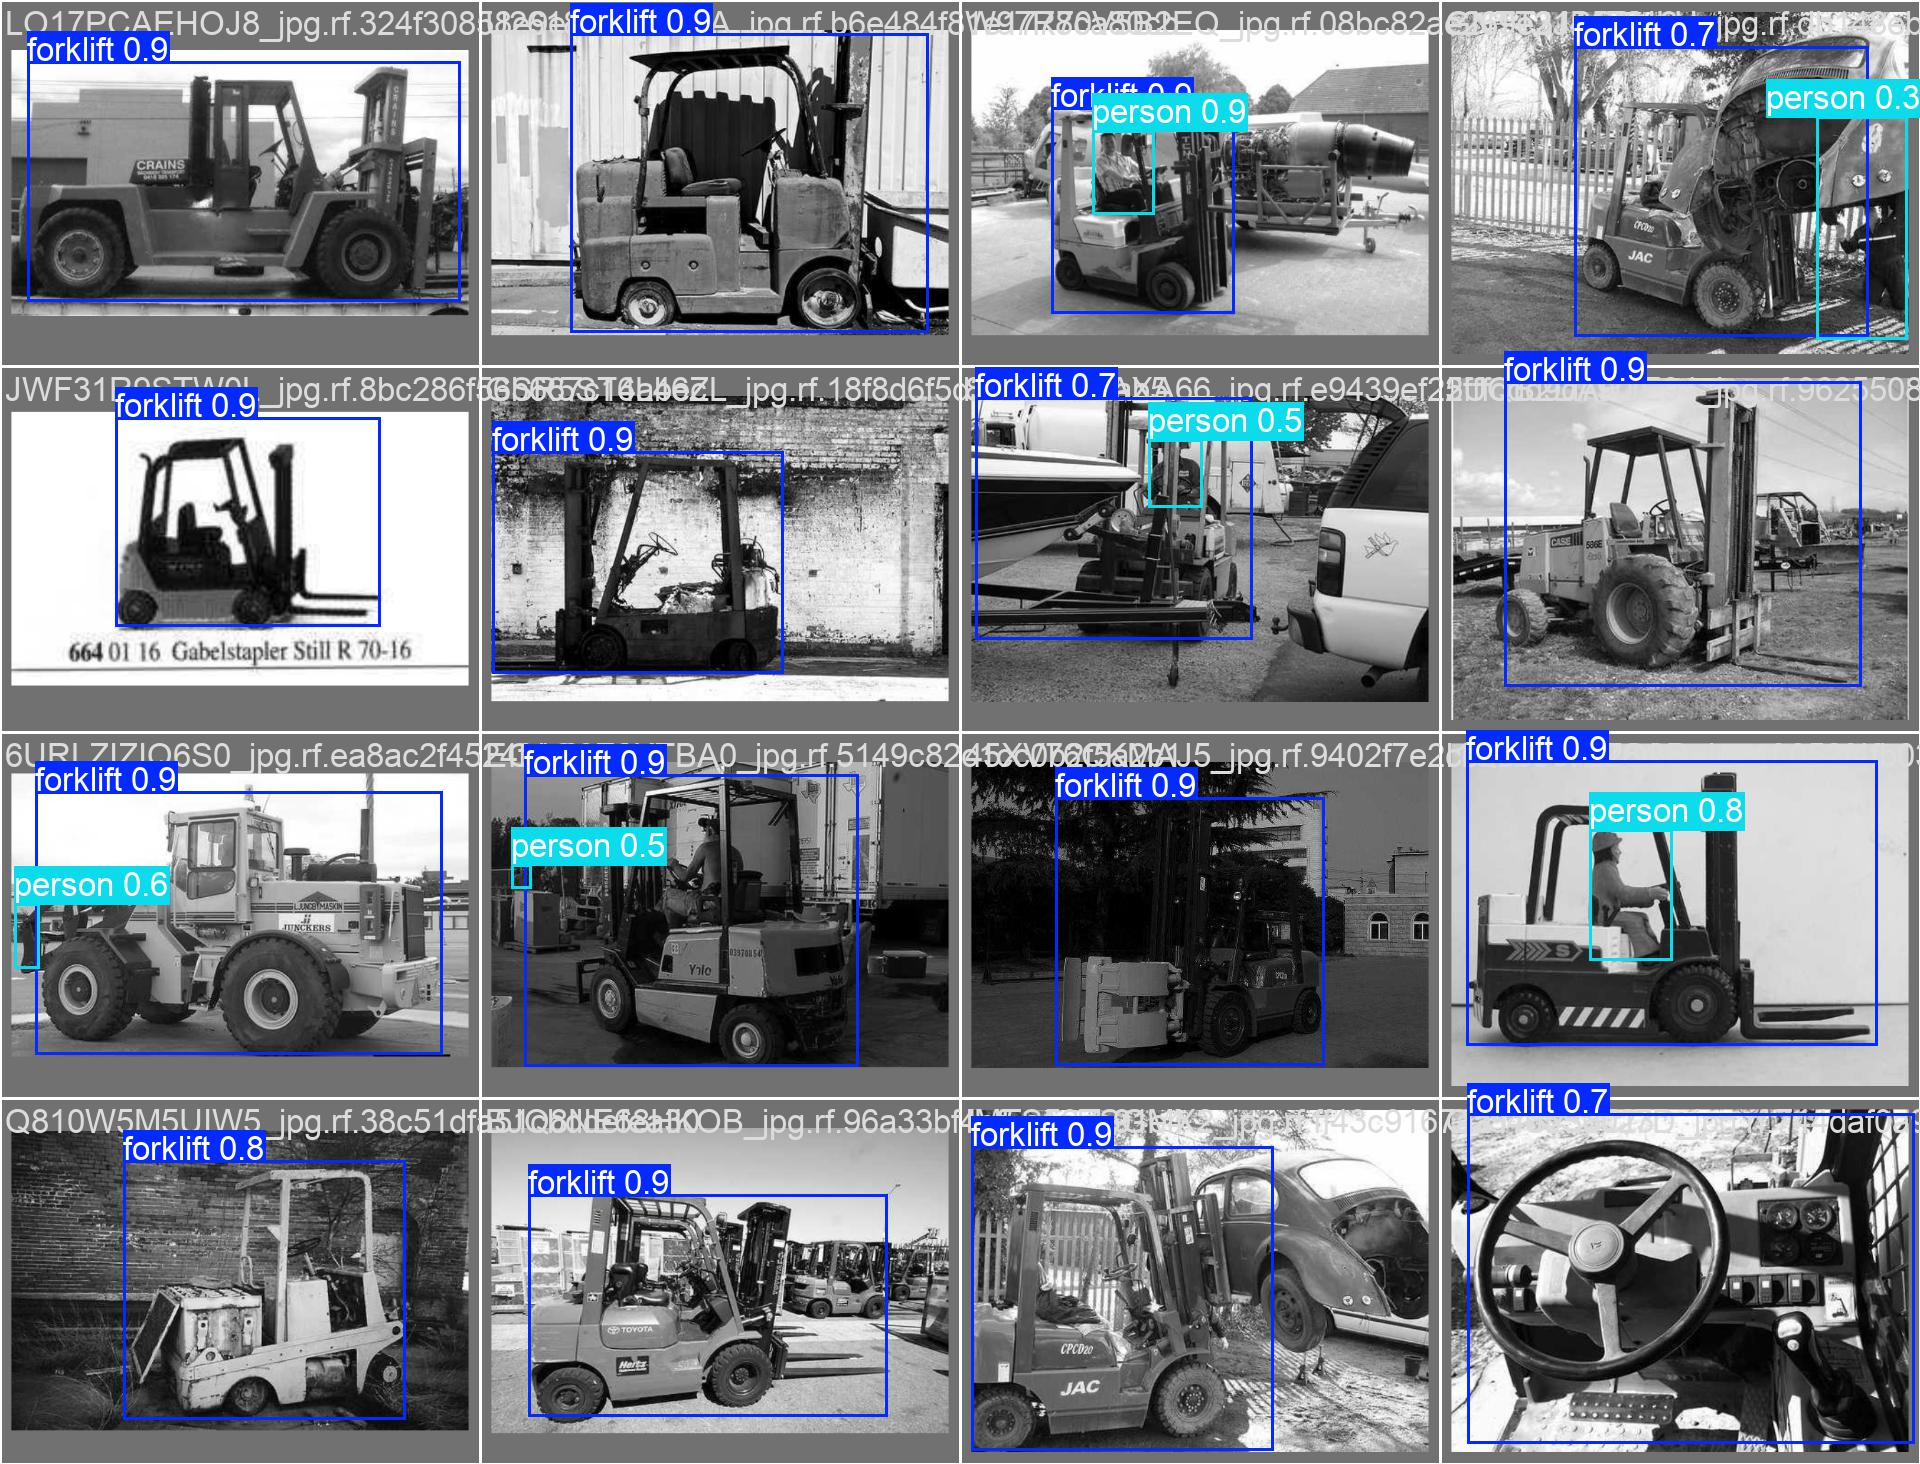

In [16]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [17]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.12.4 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
                   all         84        171      0.835        0.7      0.743      0.497
              forklift         83         96      0.957      0.854      0.917      0.674
                person         40         75      0.712      0.547       0.57      0.321
Speed: 0.8ms preprocess, 6.7ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs\detect\val
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning D:\Code\yolo_tutorial\datasets\Forklift-1\valid\labels.cache... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<?, ?it/s]
val: Scanning D:\Code\yolo_tutorial\datasets\Forklift-1\valid\labels.cache... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 1/6 [00:01<00:09,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 2/6 [00:02<00:03,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:02<00:01,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 4/6 [00:02<00:00,  2.19it/s]
                

## Inference with custom model

In [18]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.12.4 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/42 d:\Code\yolo_tutorial\datasets\Forklift-1\test\images\052IJLOWFGWF_jpg.rf.46846c682125bdd3c4093b10d3ce257e.jpg: 480x640 3 forklifts, 1 person, 42.6ms
image 2/42 d:\Code\yolo_tutorial\datasets\Forklift-1\test\images\0J1QKF0HYLEZ_jpg.rf.03163b10d4627721c7bdad71c0595797.jpg: 480x640 1 forklift, 25.6ms
image 3/42 d:\Code\yolo_tutorial\datasets\Forklift-1\test\images\1Z2J2ECZ7K49_jpg.rf.0cf6ce1f861436a118b47f4c4bdcda3b.jpg: 512x640 1 forklift, 45.1ms
image 4/42 d:\Code\yolo_tutorial\datasets\Forklift-1\test\images\26AJCLLVBKTB_jpg.rf.8b21fcc7aac2cca2e3da4c06016be20a.jpg: 480x640 1 forklift, 2 persons, 6.7ms
image 5/42 d:\Code\yolo_tutorial\datasets\Forklift-1\test\images\3L0H5SMWSJOU_jpg.rf.21b7776c1d270ddc811bab336290ef8a.jpg: 480x640 2 forklifts, 7.2ms
image 6/42 d:\Code\yolo_tutorial\datasets\Forkli

**NOTE:** Let's take a look at few results.

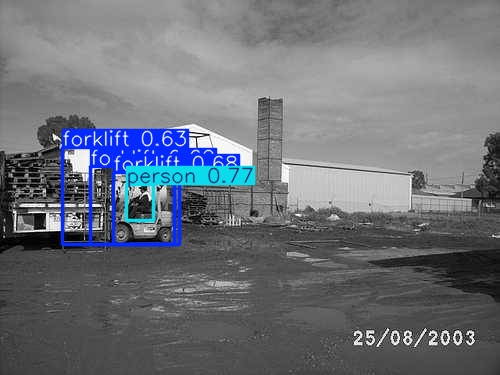

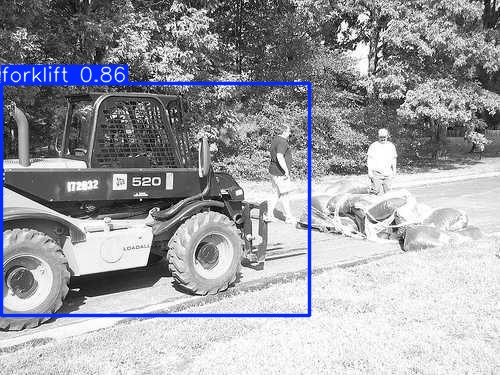

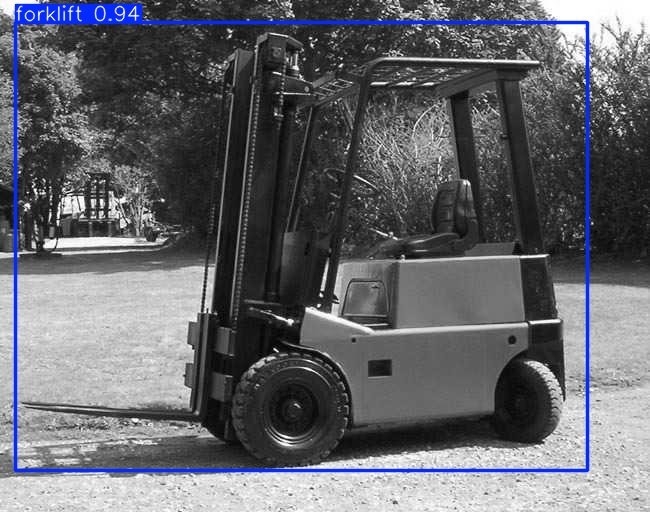

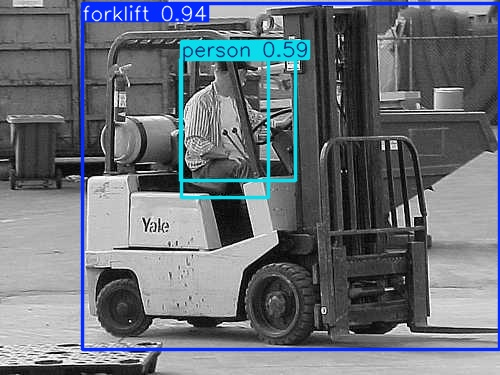

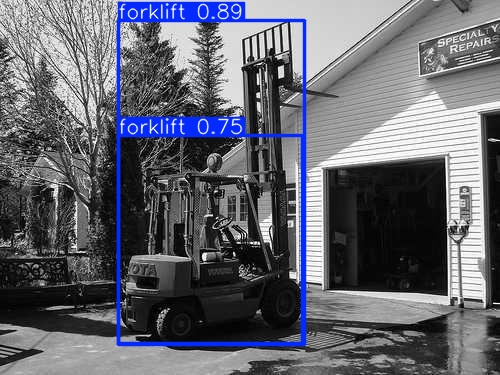

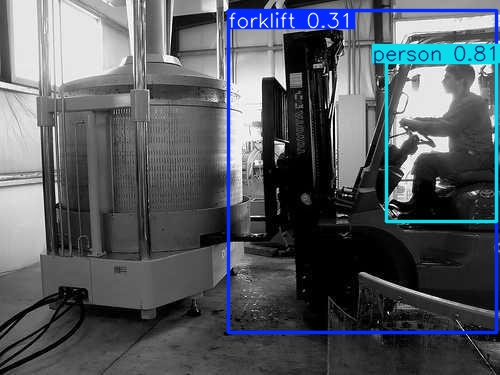

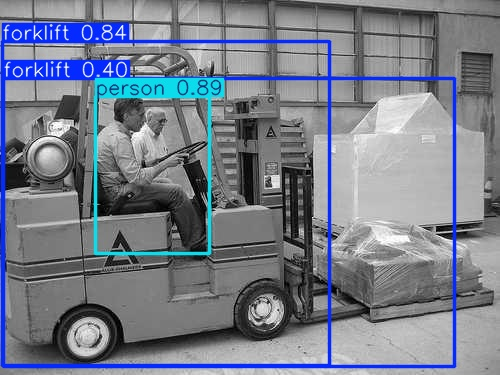

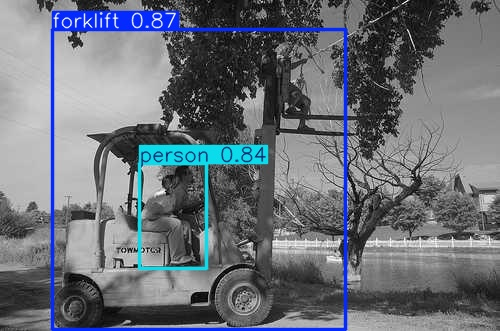

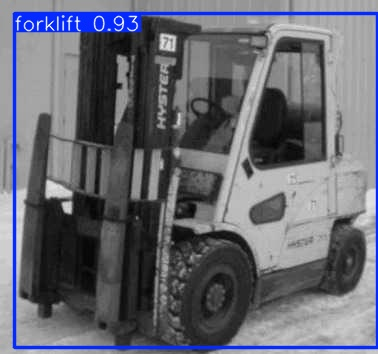

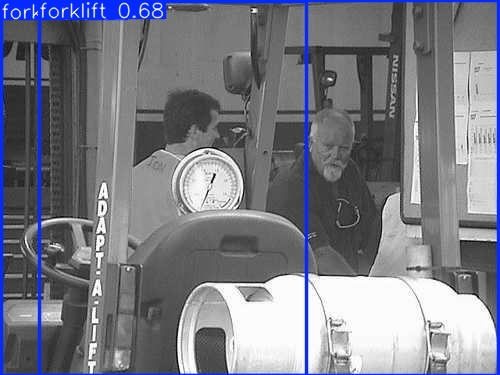

In [19]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:10]:
    display(IPyImage(filename=img, width=600))
    print("\n")